In [ ]:
# Copyright (c) 2018 The Harmonica Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
#
# This code is part of the Fatiando a Terra project (https://www.fatiando.org)
#
"""
Function to calculate the thickness of the roots and antiroots assuming the
Airy isostatic hypothesis.
"""
import numpy as np
import xarray as xr


def isostasy_airy(
    topography,
    ice_thickness=0,
    water_thickness=0,
    seawater_thickness=0,
    sediment_thickness=0,
    density_ice=0.98e3,
    density_water=1e3,
    density_seawater=1.03e3,
    density_sediment=2.4e3,
    density_crust=2.8e3,
    density_mantle=3.3e3,
    reference_depth=30e3,
):
    r"""
    Calculate the isostatic Moho depth from topography using Airy's hypothesis.
    According to the Airy hypothesis of isostasy, topography above sea level is
    supported by a thickening of the crust (a root) while oceanic basins are
    supported by a thinning of the crust (an anti-root). This assumption is
    usually
    .. figure:: ../../_static/figures/airy-isostasy.svg
        :align: center
        :width: 400px
        *Schematic of isostatic compensation following the Airy hypothesis.*
    The relationship between the topographic/bathymetric heights (:math:`h`)
    and the root thickness (:math:`r`) is governed by mass balance relations
    and can be found in classic textbooks like [TurcotteSchubert2014]_ and
    [Hofmann-WellenhofMoritz2006]_.
    On the continents (positive topographic heights):
    .. math ::
        r = \frac{\rho_{c}}{\rho_m - \rho_{c}} h
    while on the oceans (negative topographic heights):
    .. math ::
        r = \frac{\rho_{c} - \rho_w}{\rho_m - \rho_{c}} h
    in which :math:`h` is the topography/bathymetry, :math:`\rho_m` is the
    density of the mantle, :math:`\rho_w` is the density of the water, and
    :math:`\rho_{c}` is the density of the crust.
    The computed root thicknesses will be added to the given reference Moho
    depth (:math:`H`) to arrive at the isostatic Moho depth. Use
    ``reference_depth=0`` if you want the values of the root thicknesses
    instead.
    Parameters
    ----------
    topography : array or :class:`xarray.DataArray`
        Topography height and bathymetry depth in meters. It is usually prudent
        to use floating point values instead of integers to avoid integer
        division errors.
    density_crust : float
        Density of the crust in :math:`kg/m^3`.
    density_mantle : float
        Mantle density in :math:`kg/m^3`.
    density_water : float
        Water density in :math:`kg/m^3`.
    reference_depth : float
        The reference Moho depth (:math:`H`) in meters.
    Returns
    -------
    moho_depth : array or :class:`xarray.DataArray`
         The isostatic Moho depth in meters.
    """
    # Need to cast to array to make sure numpy indexing works as expected for
    
    # Define scale factor to calculate rock equvalent topography
    scale_ice = density_ice / density_crust
    scale_water = density_water / density_crust
    scale_seawater = density_seawater / density_crust
    scale_sediment = density_sediment / density_crust
    scale = density_crust / (density_mantle-density_crust)
    # Calculate rock equvalent topography
    RET = topography + ice_thickness*scale_ice + water_thickness*scale_water + seawater_thickness*scale_seawater + sediment_thickness*scale_sediment

    moho = RET * scale + reference_depth
    if isinstance(moho, xr.DataArray):
        moho.name = "moho_depth"
        moho.attrs["isostasy"] = "Airy"
        moho.attrs["density_crust"] = str(density_crust)
        moho.attrs["density_mantle"] = str(density_mantle)
        moho.attrs["density_water"] = str(density_water)
        moho.attrs["reference_depth"] = str(reference_depth)
    return moho

<xarray.DataArray 'moho_depth' (latitude: 171, longitude: 161)>
array([[25772.4, 25929.6, 25989.6, ..., 23828.4, 23800.8, 23728.8],
       [25842. , 25982.4, 26162.4, ..., 23707.2, 23706. , 23685.6],
       [25753.2, 25914. , 26137.2, ..., 23650.8, 23698.8, 23694. ],
       ...,
       [24966. , 24502.8, 24372. , ..., 30229.6, 30207.2, 30218.4],
       [24967.2, 24649.2, 24448.8, ..., 30184.8, 30162.4, 30162.4],
       [24962.4, 24787.2, 24542.4, ..., 30207.2, 30184.8, 30162.4]])
Coordinates:
  * longitude  (longitude) float64 -20.0 -19.5 -19.0 -18.5 ... 59.0 59.5 60.0
  * latitude   (latitude) float64 -40.0 -39.5 -39.0 -38.5 ... 44.0 44.5 45.0
Attributes:
    isostasy:         Airy
    density_crust:    2800.0
    density_mantle:   3300.0
    density_water:    1000.0
    reference_depth:  30000.0


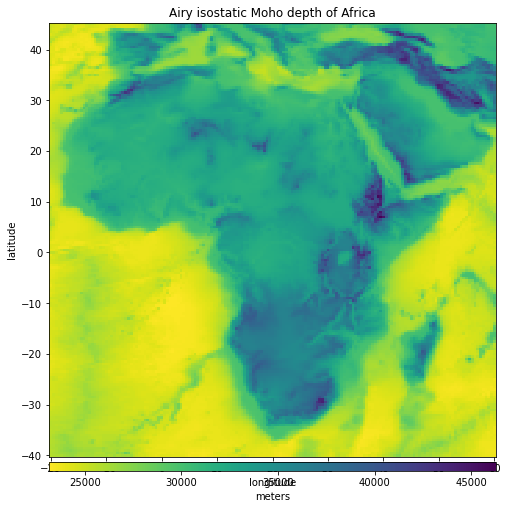

In [3]:
import matplotlib.pyplot as plt

import harmonica as hm

# Load the elevation model and cut out the portion of the data corresponding to
# Africa
data = hm.datasets.fetch_topography_earth()
region = (-20, 60, -40, 45)
data_africa = data.sel(latitude=slice(*region[2:]), longitude=slice(*region[:2]))
#print("Topography/bathymetry grid:")
#print(data_africa)

oceans = np.array(data_africa.topography < 0)
water_thick = data_africa.topography*oceans*-1

sedi_thick=water_thick*0.5
# Calculate the isostatic Moho depth using the default values for densities and
# reference Moho
moho = isostasy_airy(data_africa.topography,water_thickness=water_thick,sediment_thickness=sedi_thick)
#print("\nMoho depth grid:")
print(moho)
# Draw the maps

plt.figure(figsize=(8, 9.5))
ax = plt.axes()
pc = moho.plot.pcolormesh(
    ax=ax, cmap="viridis_r", add_colorbar=False
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.01, aspect=50, label="meters")
ax.set_title("Airy isostatic Moho depth of Africa")
plt.show()
